<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [1]:
import sys
import os
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary
from torch.utils.data import ConcatDataset
import datetime
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import string
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset

In [2]:


trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
trans_augmentation = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(10, fill=(0,)),torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  train_set_augmentation = torchvision.datasets.EMNIST(root=dataset_path, transform=trans_augmentation,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

augmentated_train_loader  = torch.utils.data.DataLoader(
                 dataset=ConcatDataset((train_set,train_set_augmentation)),
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print("load train_loader")
preload_train_data = list(enumerate(train_loader))
preload_augmentated_train_data = list(enumerate(augmentated_train_loader))
print("load test_loader")
preload_test_data = list(enumerate(test_loader))

CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set
load train_loader
load test_loader


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss,acc_result):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.plot(acc_result,label='accuracy')
  best_accuracy = np.amax(acc_result)
  best_epoch = np.argmax(acc_result)
  ax.annotate(f"\nBest Accuracy:{best_acc:.5f} at epoch {best_epoch}", 
              xy=(best_epoch, best_accuracy),
              color="blue",
              xytext=(0.2*len(acc_result), best_accuracy-0.2),
              arrowprops=dict(facecolor='blue', shrink=0.05),
              )
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()
def plot_confusion_matrix(name,pred,ans):
  classes=list(range(0,10))+list(string.ascii_uppercase)+list(string.ascii_lowercase)
  conf_matrix = confusion_matrix(pred, ans)
  fig, ax = plt.subplots()
  n = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  ax.set(title=name)
  fig.colorbar(n,aspect=30,ax=ax,fraction=0.03)
  tick_marks = np.arange(len(classes))
  ax.set_xticks(tick_marks)
  ax.set_yticks(tick_marks)  
  ax.set_xticklabels(classes)
  ax.set_yticklabels(classes)

  fmt = 'd'
  thresh = conf_matrix.max() / 2.
  for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
      ax.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')
  fig.set_size_inches(25, 25)
  fig.tight_layout()
  plt.show()


# Define CNN

In [0]:
#CNN
class ConvolutioNeuralNetwork (torch.nn.Module):
    def __init__(self,dropout=0,batch_norm=False):
        super(ConvolutioNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_bn = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 500)
        self.final = nn.Linear(500, 62)
        self.dropout=dropout
        self.batch_norm = batch_norm
    def forward(self, x):
        x = F.dropout(x,p = self.dropout)
        x = F.relu(self.conv1(x))
        if self.batch_norm:
            x = self.conv1_bn(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout(x,p = self.dropout)        
        x = F.relu(self.conv2(x))
        if self.batch_norm:
            x = self.conv2_bn(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))     
        x = F.relu(self.fc2(x))
        x = self.final(x)
        return x
    @property
    def name(self):
        return f"CNN, Dropout: {self.dropout}, Batch Normalization: {self.batch_norm}"    

2020-04-12 14:59:41.276107
CNN, Dropout: 0, Batch Normalization: False Original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.85361,1:0.86160,2:0.86517,3:0.86558,4:0.86593,5:0.86646,6:0.86589,7:0.86472,8:0.86329,9:0.86204,10:0.85950,11:0.85755,12:0.85629,13:0.85343,14:0.85324

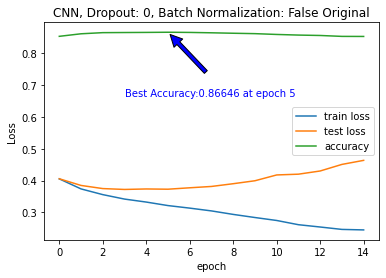

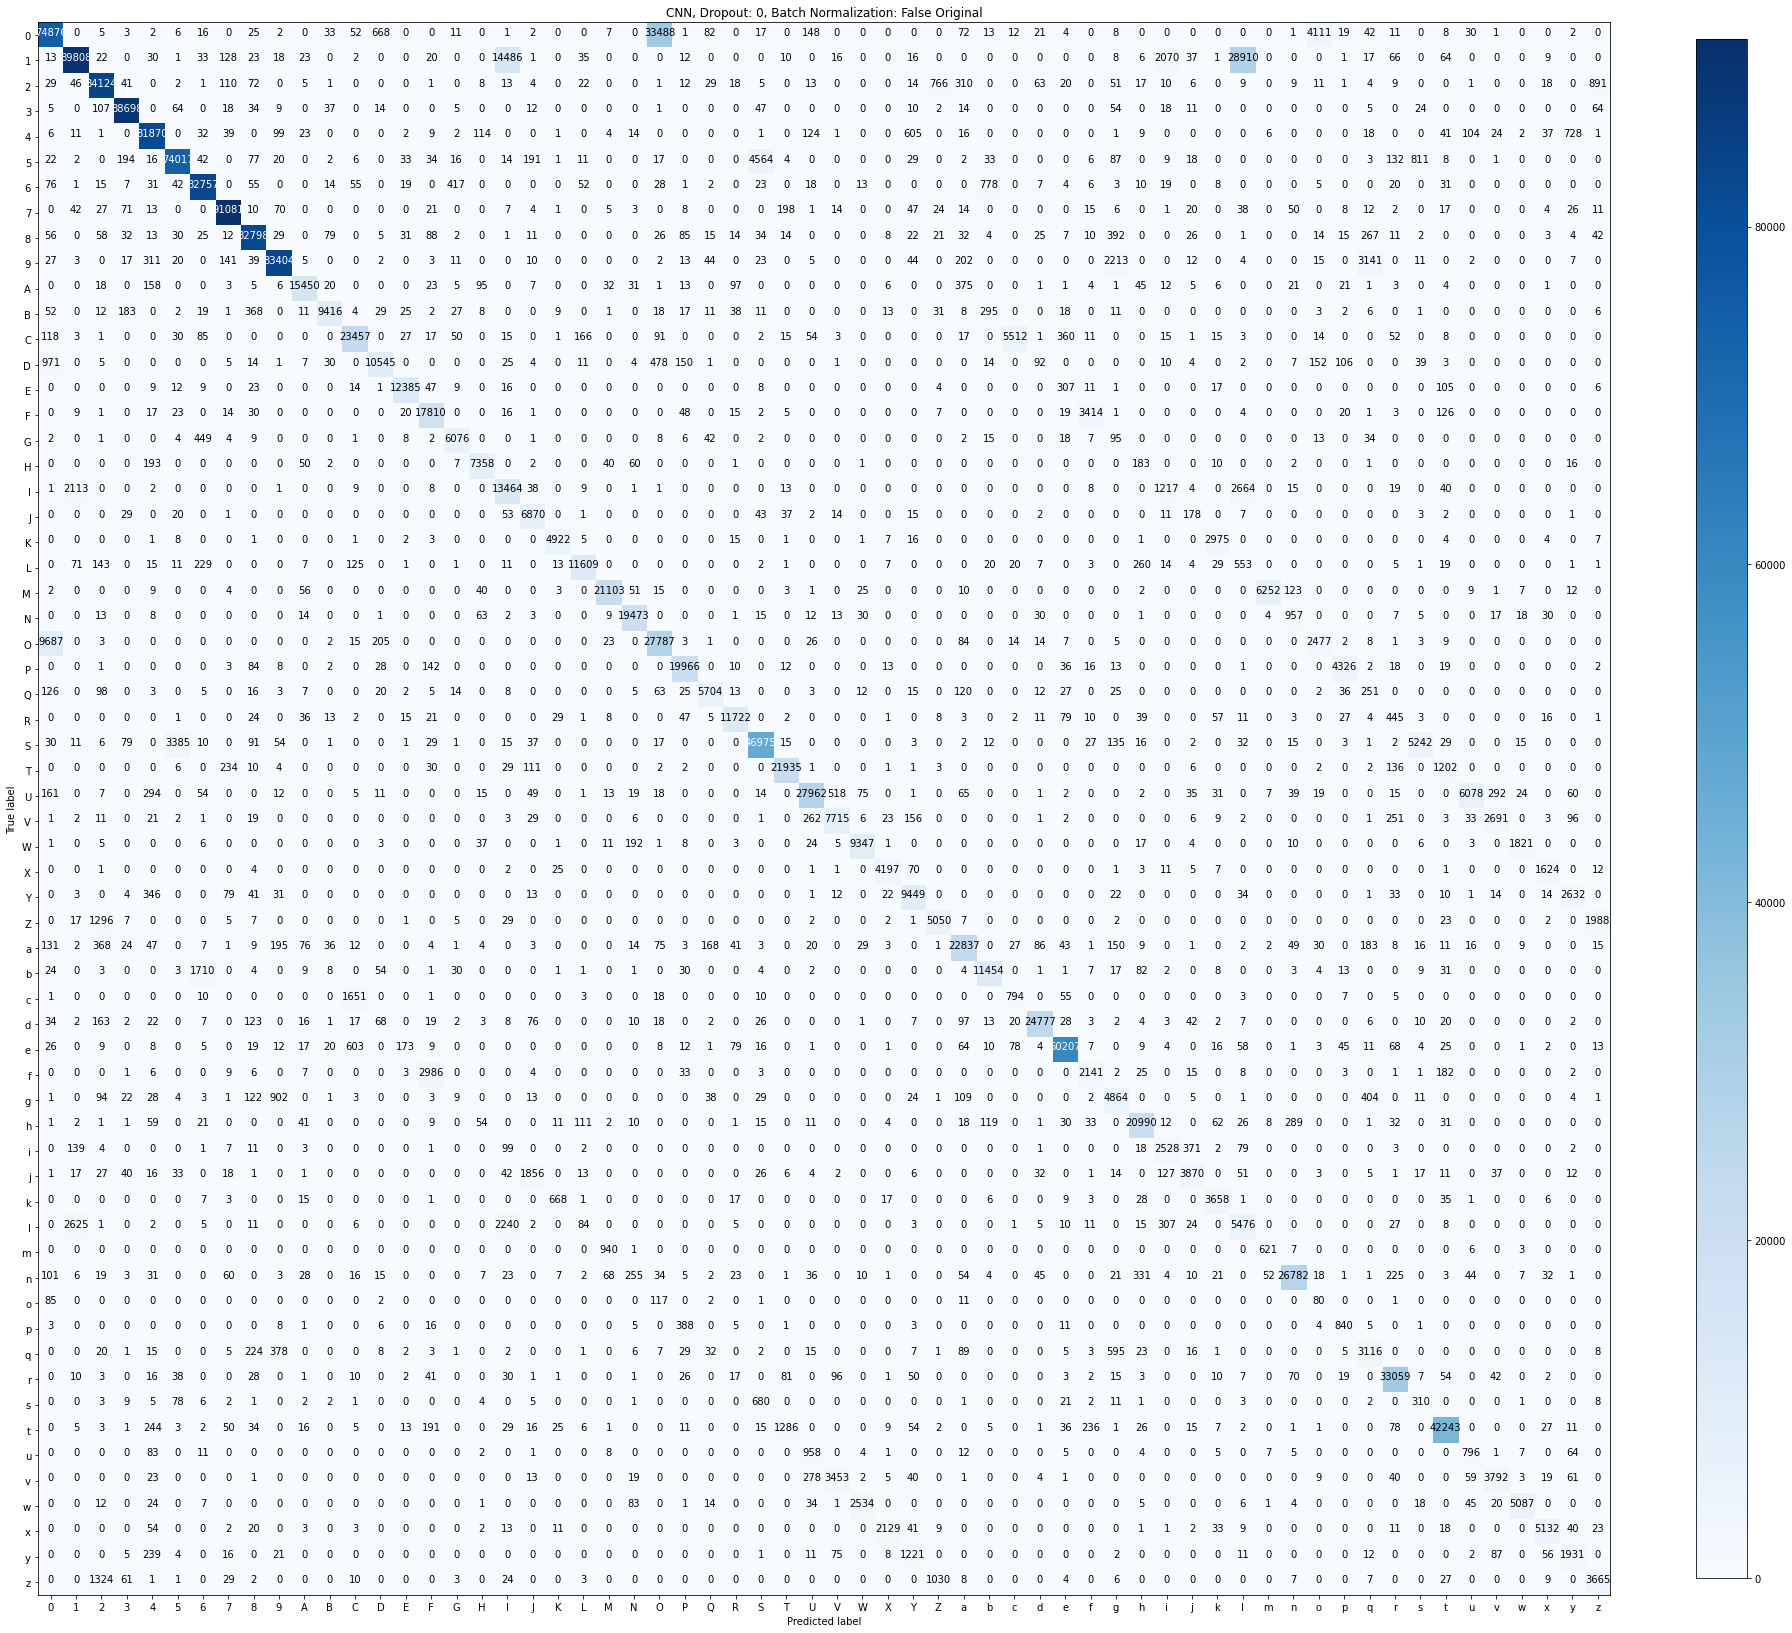

2020-04-12 15:03:18.679726
CNN, Dropout: 0, Batch Normalization: True Original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
       BatchNorm2d-2           [-1, 20, 24, 24]              40
            Conv2d-3             [-1, 50, 8, 8]          25,050
       BatchNorm2d-4             [-1, 50, 8, 8]             100
            Linear-5                  [-1, 500]         400,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                   [-1, 62]          31,062
Total params: 707,772
Trainable params: 707,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.70
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
0:0.86182,1:0.86452,2:0.866

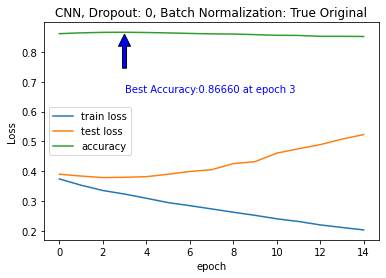

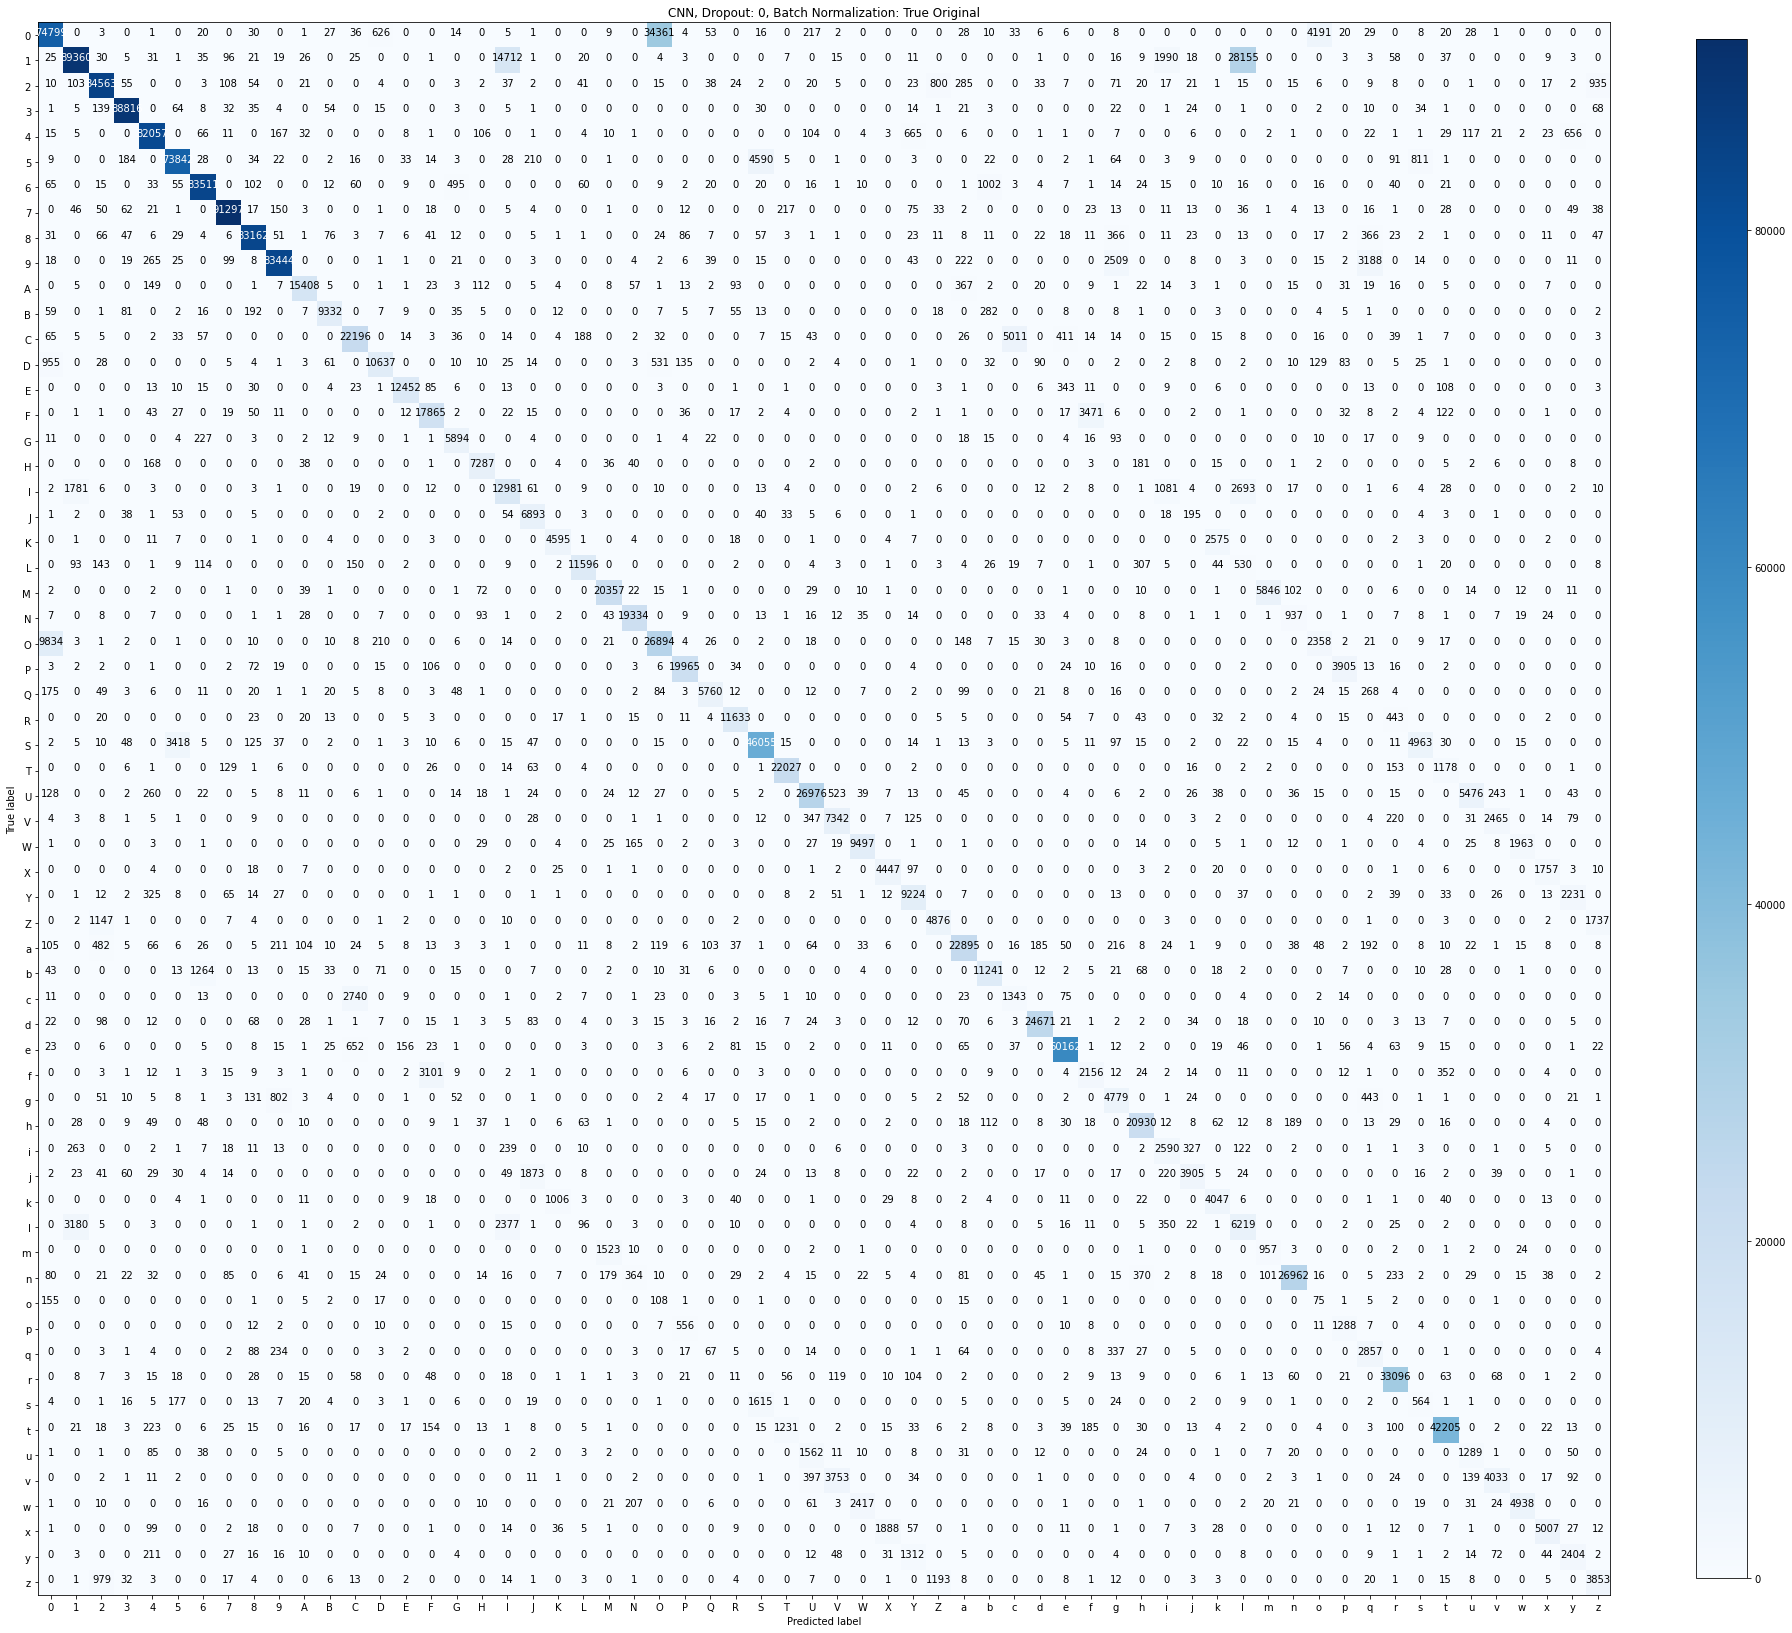

2020-04-12 15:07:18.618108
CNN, Dropout: 0.1, Batch Normalization: False Original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.84936,1:0.85670,2:0.86066,3:0.86342,4:0.86364,5:0.86433,6:0.86311,7:0.86401,8:0.86237,9:0.86239,10:0.86320,11:0.86054,12:0.86173,13:0.85963,14:0.859

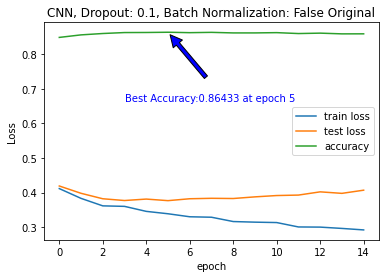

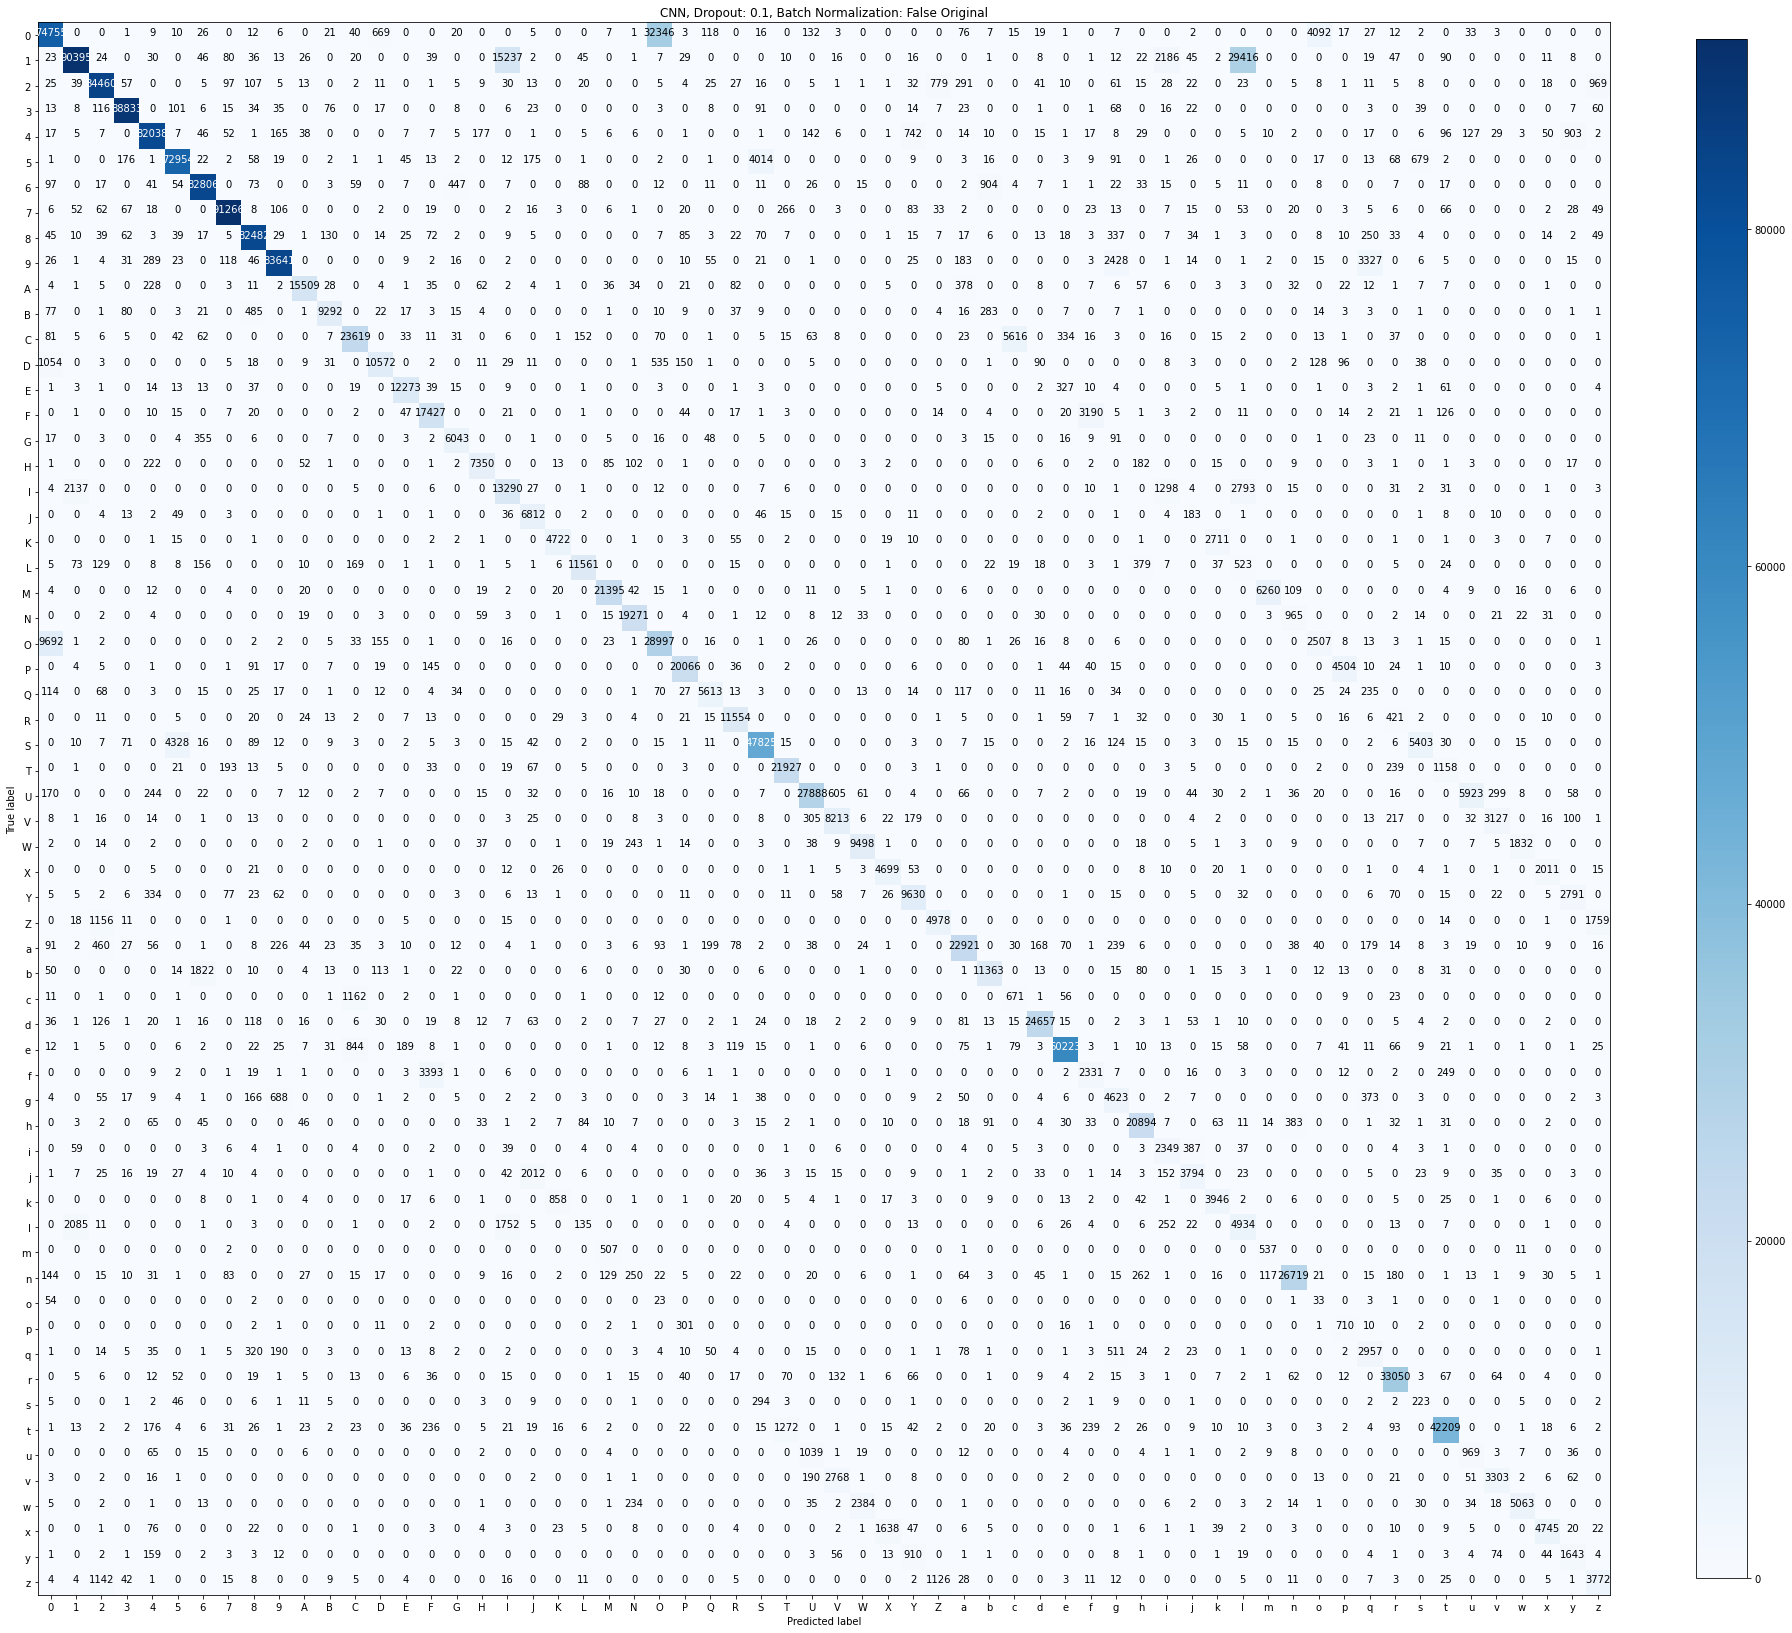

2020-04-12 15:10:56.096654
CNN, Dropout: 0.1, Batch Normalization: True Original
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
       BatchNorm2d-2           [-1, 20, 24, 24]              40
            Conv2d-3             [-1, 50, 8, 8]          25,050
       BatchNorm2d-4             [-1, 50, 8, 8]             100
            Linear-5                  [-1, 500]         400,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                   [-1, 62]          31,062
Total params: 707,772
Trainable params: 707,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.70
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
0:0.85557,1:0.85985,2:0.8

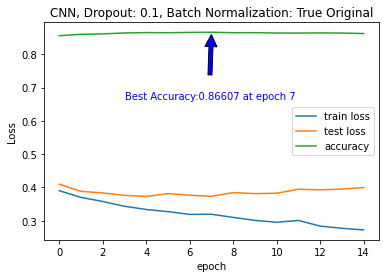

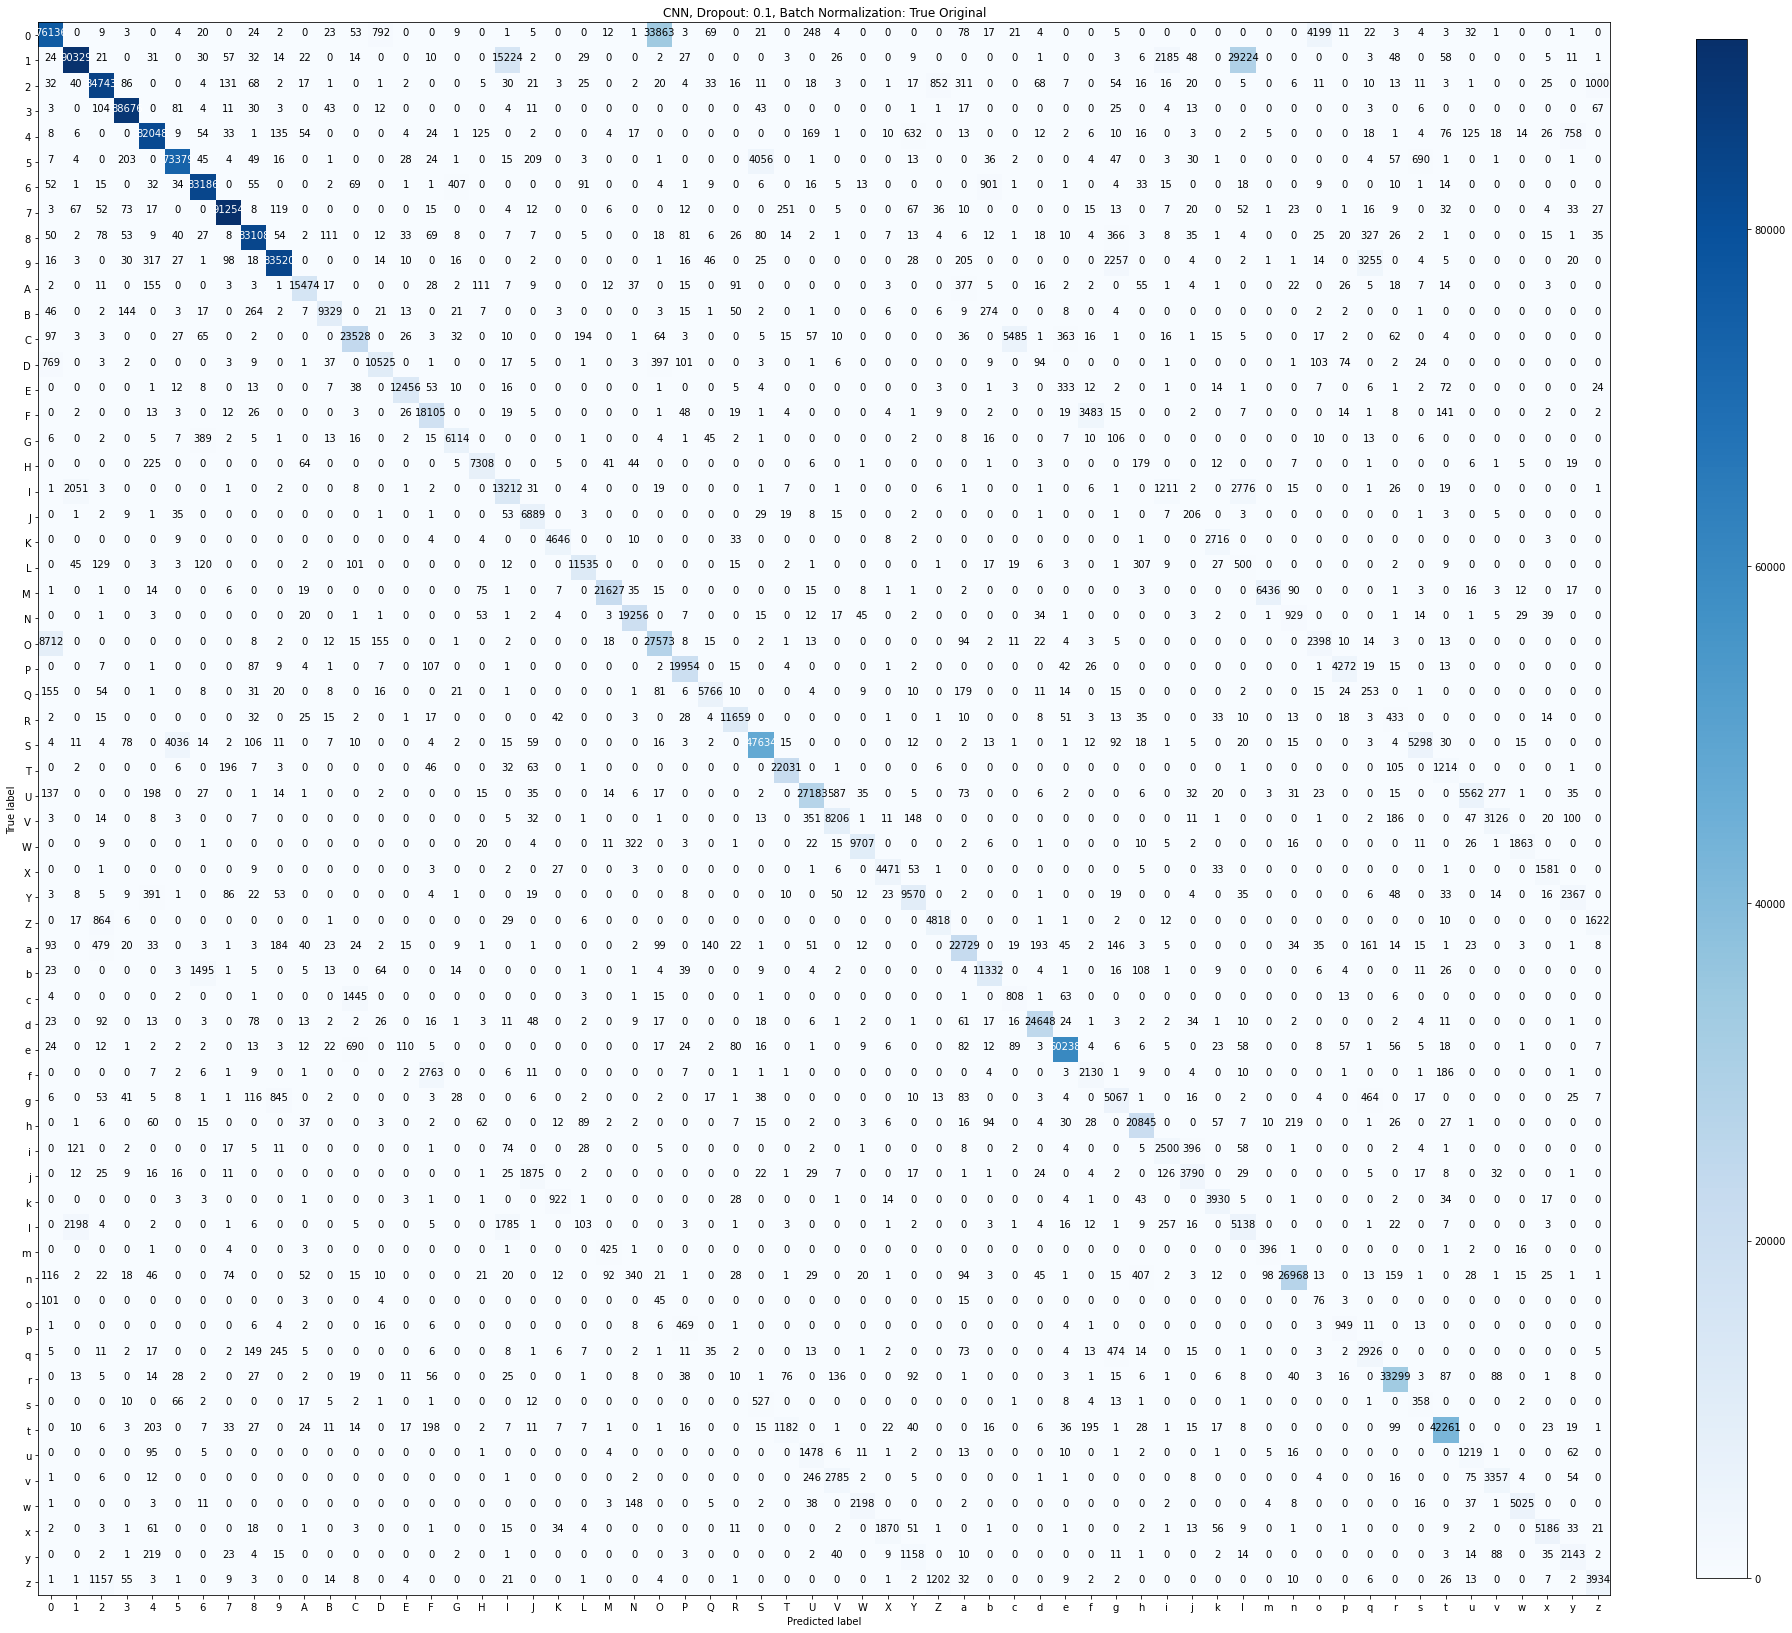

2020-04-12 15:14:57.885750
CNN, Dropout: 0, Batch Normalization: False Argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.85334,1:0.86047,2:0.86231,3:0.86390,4:0.86378,5:0.86271,6:0.86212,7:0.86013,8:0.85733,9:0.85659,10:0.85432,11:0.85373,12:0.85178,13:0.84885,14:0.

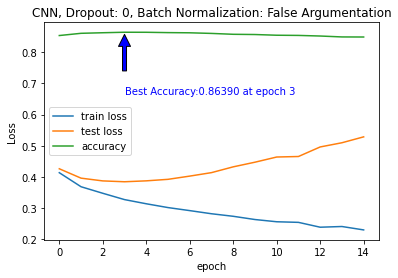

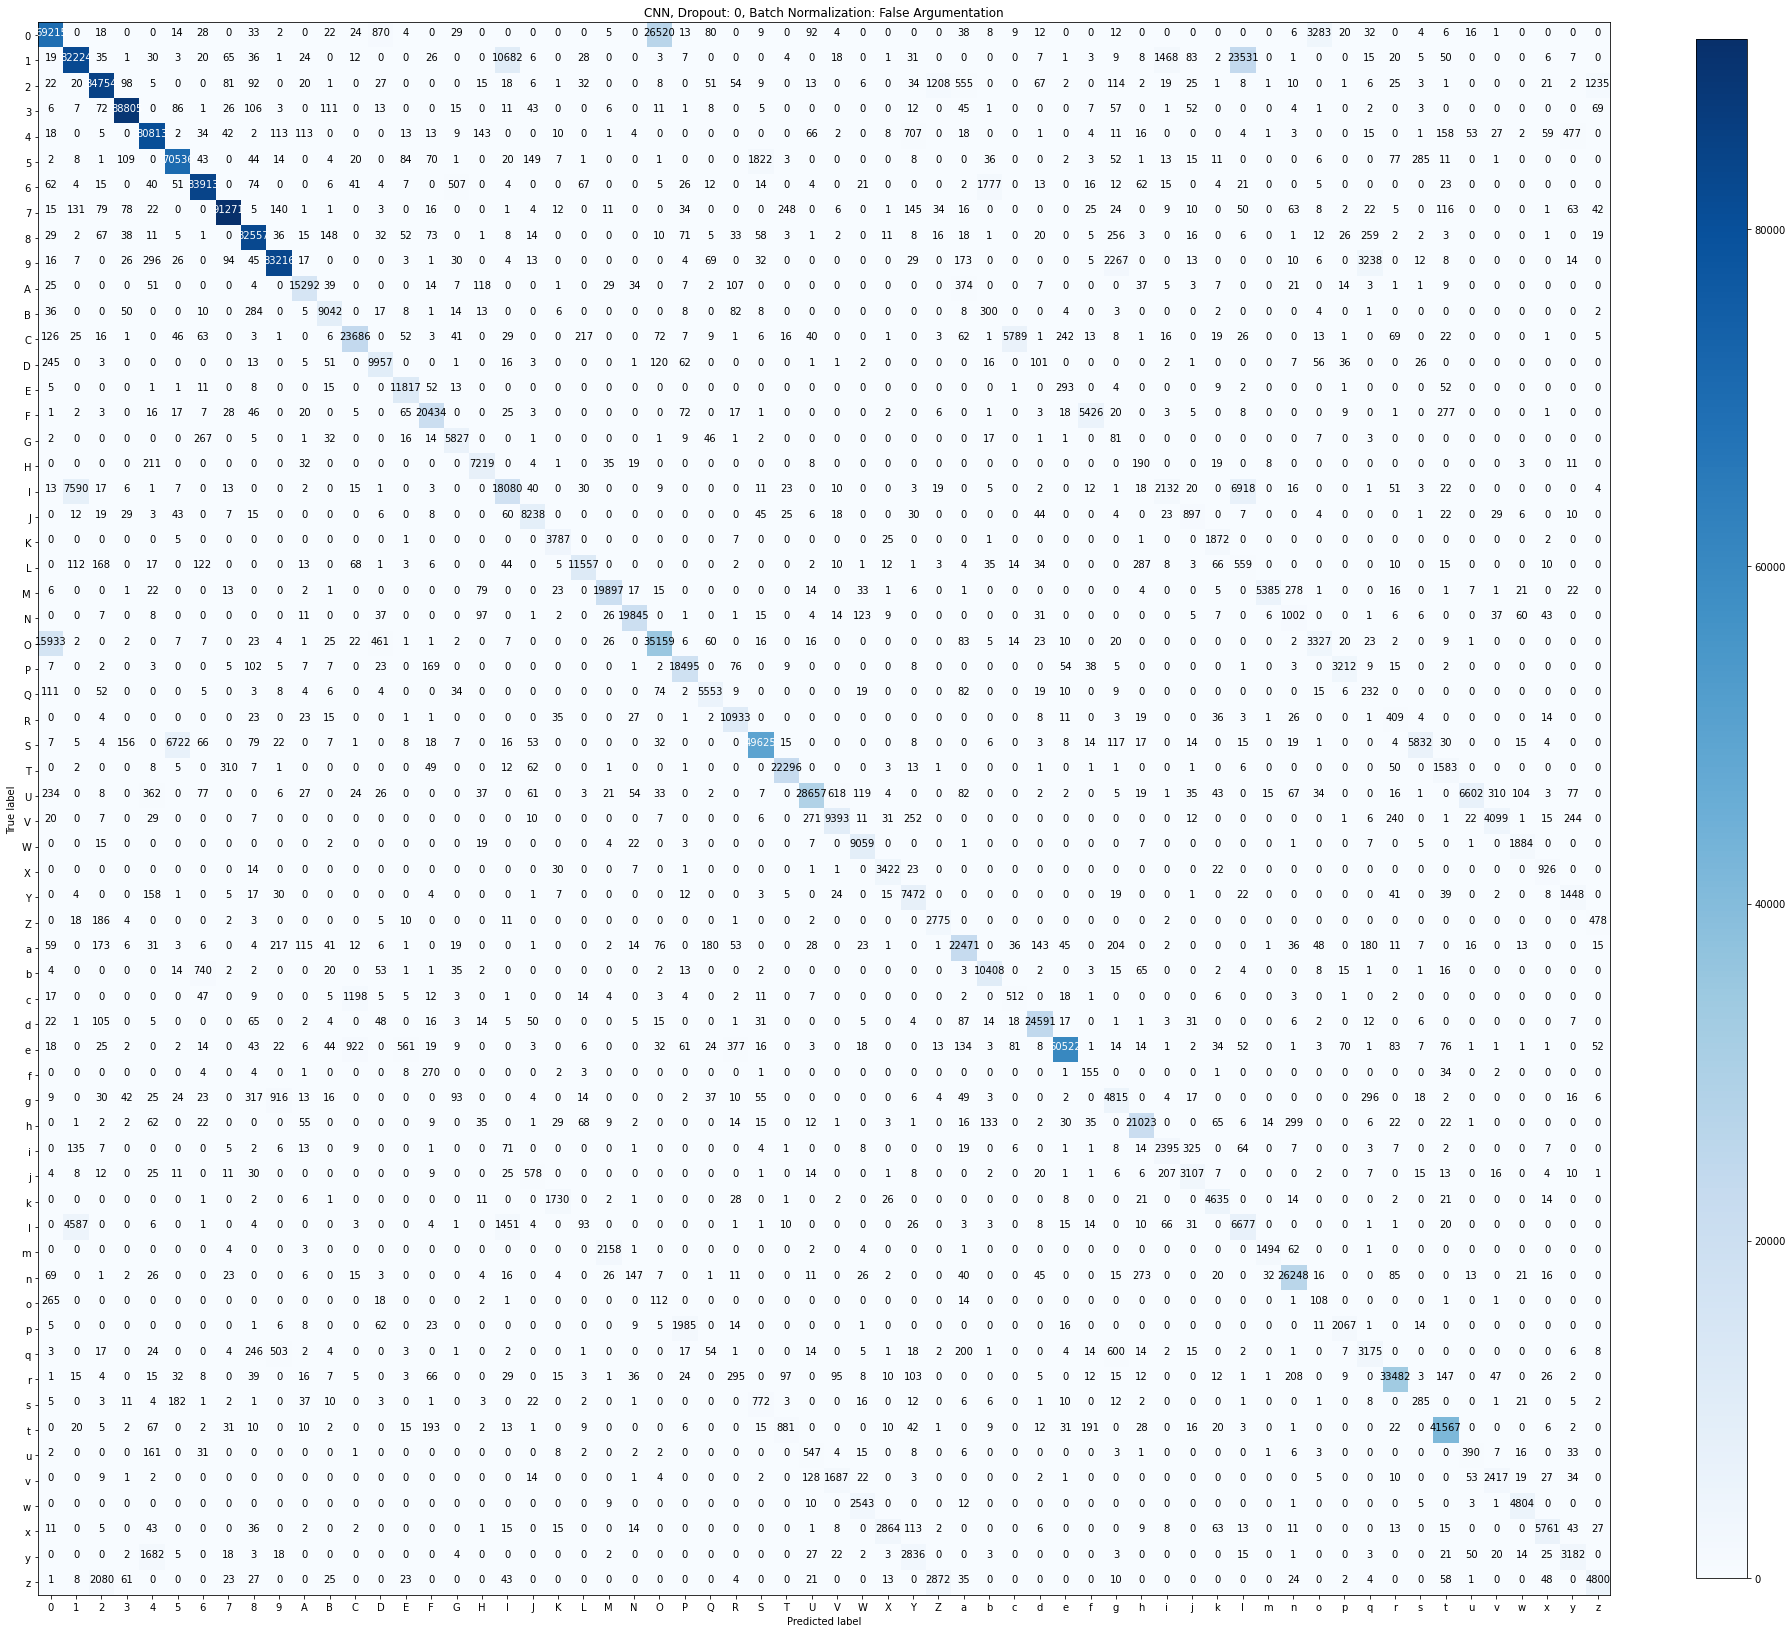

2020-04-12 15:18:32.975433
CNN, Dropout: 0, Batch Normalization: True Argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
       BatchNorm2d-2           [-1, 20, 24, 24]              40
            Conv2d-3             [-1, 50, 8, 8]          25,050
       BatchNorm2d-4             [-1, 50, 8, 8]             100
            Linear-5                  [-1, 500]         400,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                   [-1, 62]          31,062
Total params: 707,772
Trainable params: 707,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.70
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
0:0.85991,1:0.86390,2:

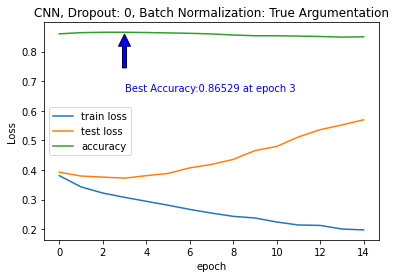

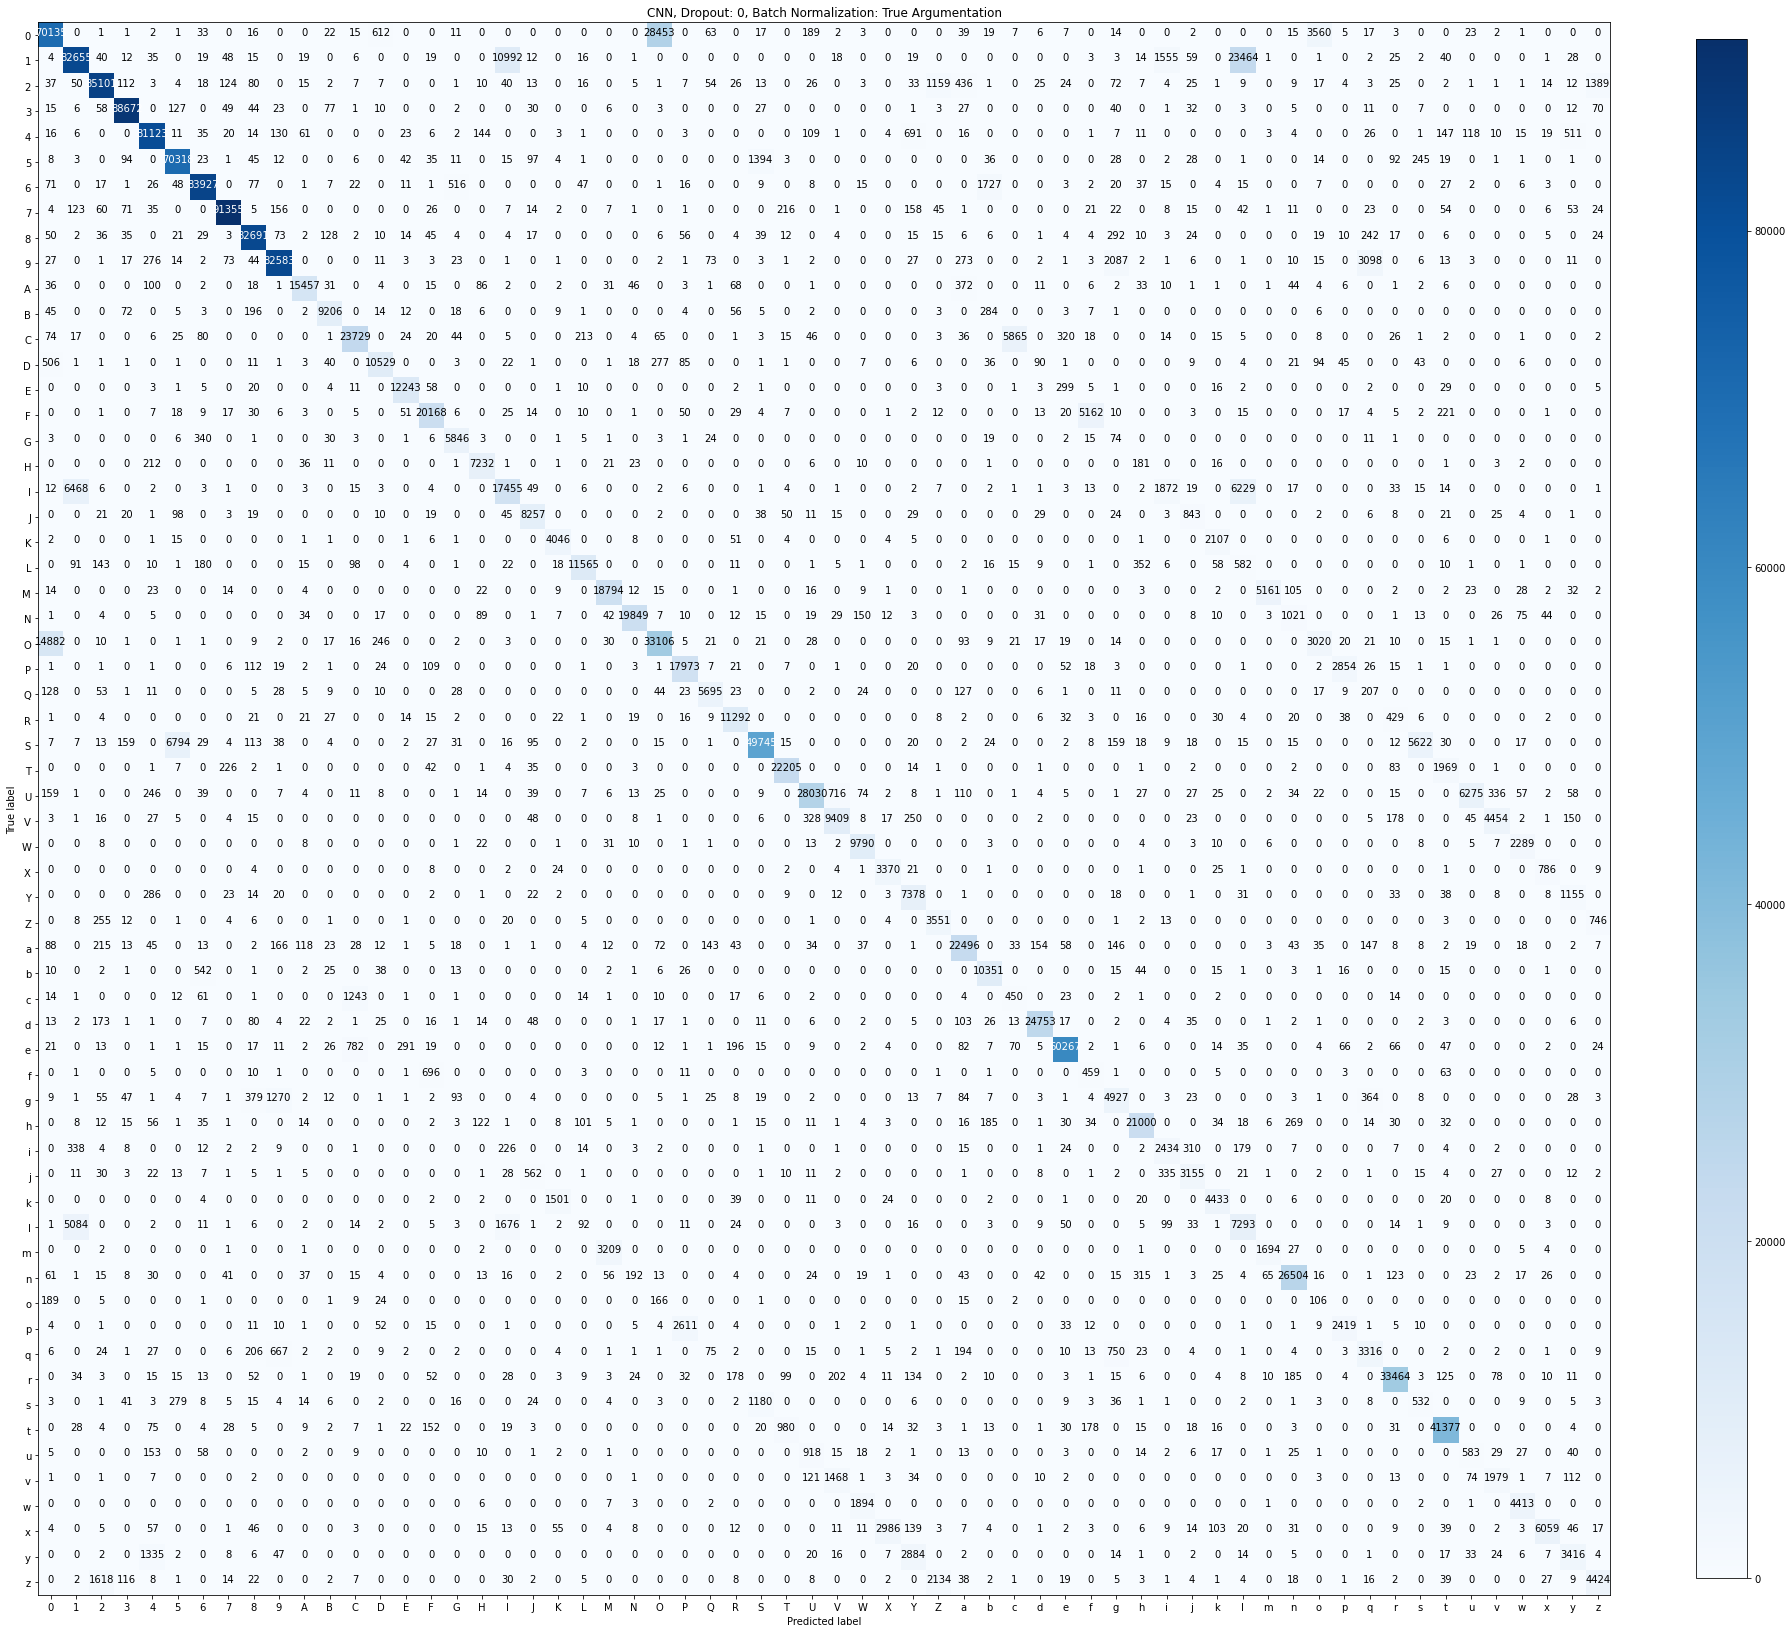

2020-04-12 15:22:33.133374
CNN, Dropout: 0.1, Batch Normalization: False Argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                  [-1, 500]         250,500
            Linear-5                   [-1, 62]          31,062
Total params: 707,632
Trainable params: 707,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.70
Estimated Total Size (MB): 2.82
----------------------------------------------------------------
0:0.84930,1:0.85642,2:0.85875,3:0.86093,4:0.86095,5:0.86263,6:0.86111,7:0.86049,8:0.86254,9:0.86027,10:0.86117,11:0.85906,12:0.85795,13:0.85861,14:

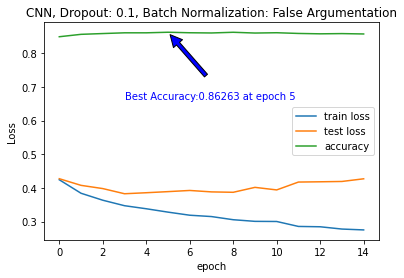

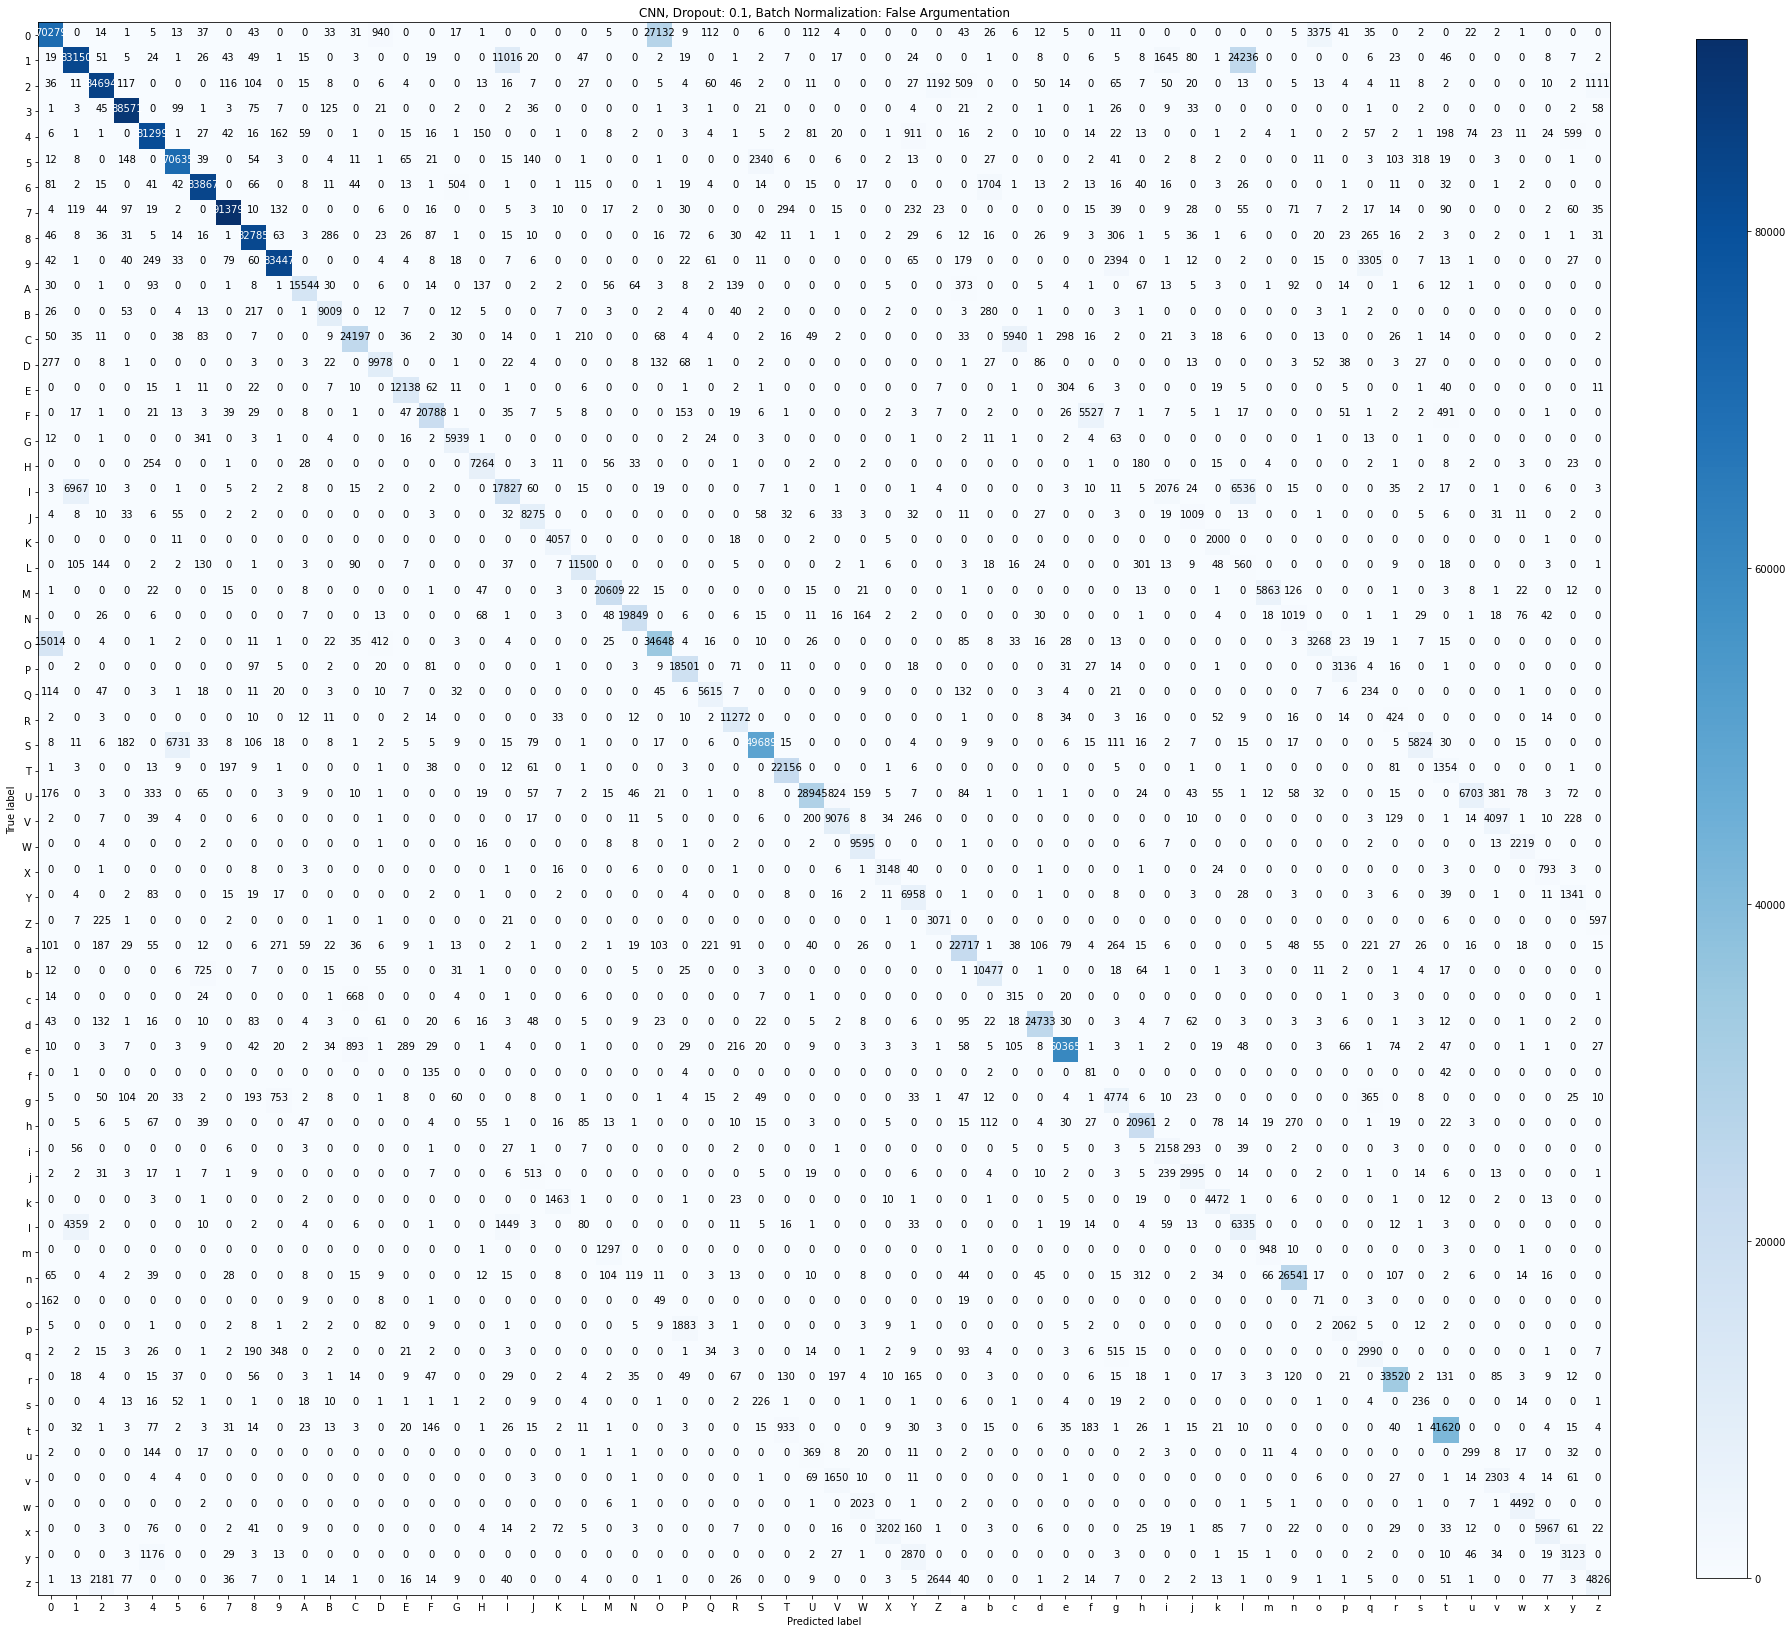

2020-04-12 15:26:12.471902
CNN, Dropout: 0.1, Batch Normalization: True Argumentation
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
       BatchNorm2d-2           [-1, 20, 24, 24]              40
            Conv2d-3             [-1, 50, 8, 8]          25,050
       BatchNorm2d-4             [-1, 50, 8, 8]             100
            Linear-5                  [-1, 500]         400,500
            Linear-6                  [-1, 500]         250,500
            Linear-7                   [-1, 62]          31,062
Total params: 707,772
Trainable params: 707,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.70
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
0:0.85453,1:0.86090,

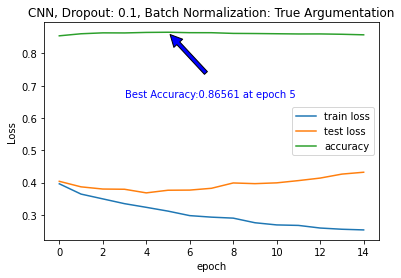

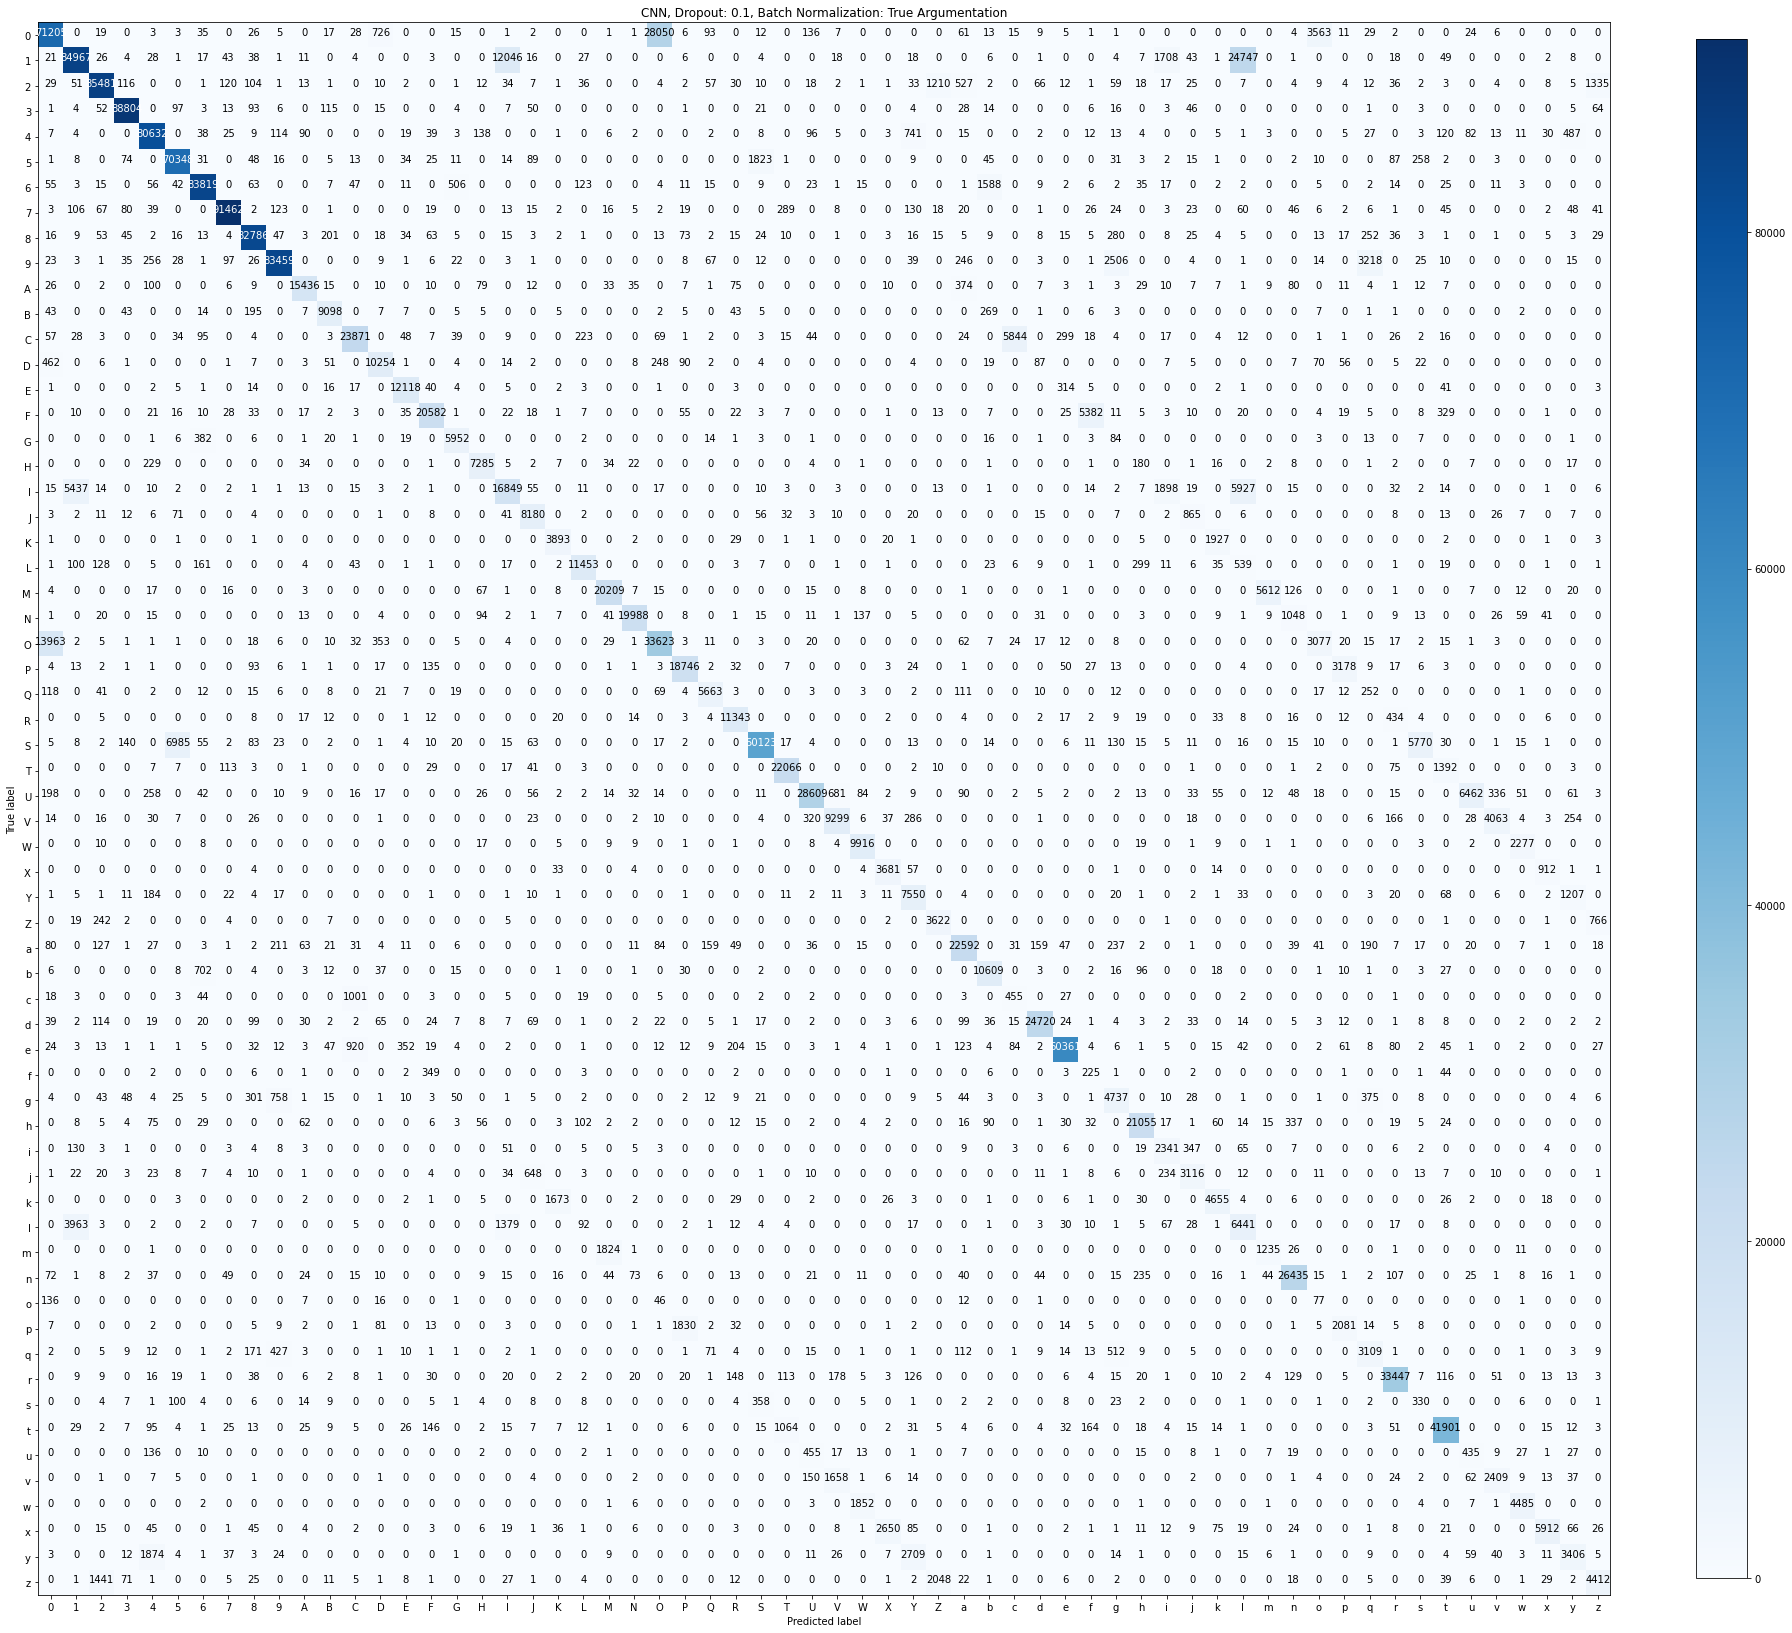

done


In [5]:
train_data_list = (
    ("Original", preload_train_data),
    ("Argumentation",preload_augmentated_train_data),
)

sample_limit = 1000000
for train_data_name,train_data in train_data_list:
  models = (
      ConvolutioNeuralNetwork(dropout = 0,batch_norm=False),
      ConvolutioNeuralNetwork(dropout = 0,batch_norm=True),       
      ConvolutioNeuralNetwork(dropout = 0.1,batch_norm=False),    
      ConvolutioNeuralNetwork(dropout = 0.1,batch_norm=True)  
  )
  for model in models:
    print(datetime.datetime.now())
    optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
    name = f'{model.name} {train_data_name}' 
    print(f'{name}')
    train_loss=[]
    test_loss=[]
    acc_result=[]
    pred = []
    ans =[]
    if use_cuda:
      model.cuda()
    model.to(torch.device("cuda"))
    summary(model,(1,28,28))
    best_acc = 0
    for epoch in range(15):
      # training
      ave_loss = 0
      for batch_idx, (x, target) in train_data:
          optimizer.zero_grad()
          if use_cuda:
              x, target = x.cuda(), target.cuda()
          out,loss = apply_model (model,x,target)
          ave_loss = ave_loss * 0.9 + loss.data* 0.1
          loss.backward()
          optimizer.step()
          if (batch_idx+1) == len(train_loader) or batch_idx >sample_limit:
              #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, train loss: {ave_loss:.6f}')
              break
      train_loss.append(ave_loss)
      # testing
      correct_cnt, ave_loss = 0, 0
      total_cnt = 0
      for batch_idx, (x, target) in preload_test_data:
          if use_cuda:
            x, target = x.cuda(), target.cuda()      
          out,loss = apply_model (model,x,target)        
          _, pred_label = torch.max(out.data, 1)
          total_cnt += x.data.size()[0]
          correct_cnt += (pred_label == target.data).sum()
         
          pred += pred_label.tolist()
          ans += target.data.tolist()
          # smooth average
          ave_loss = ave_loss * 0.9 + loss.data * 0.1
          if (batch_idx) == len(test_loader)-1 or batch_idx >sample_limit:
              #print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, test loss: {ave_loss:.6f}, acc: {correct_cnt * 1.0 / total_cnt:.3f}')
              break
      acc = correct_cnt * 1.0 / total_cnt
      print(f'{epoch}:{acc:.5f}', end=',')
      if (acc > best_acc):
        best_acc = acc
        best_epoch = epoch
      test_loss.append(ave_loss)
      acc_result.append(acc)
    print (f"\nBest Accuracy:{best_acc} at epoch {best_epoch}")  
    plot_graph(name,train_loss,test_loss,acc_result)
    plot_confusion_matrix(name,pred,ans)
print("done")